In [134]:
import os

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

plt.rcParams['figure.figsize'] = [15, 10]

df_web_search = pd.read_csv('./dataset/web-searches.csv', parse_dates=[0], index_col=0, header=0, squeeze=True)
df_query_search = pd.read_csv('./dataset/query-searches.csv', parse_dates=[0], index_col=0, header=0, squeeze=True)
print('-- Setup Complete --')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-- Setup Complete --



### Datasets

#### Web-Search Category DataFrame

Berikut adalah kunci untuk mengakses setiap data frame kategori pencarian yang didapatkan dari *Google Trending Search Interest*

Example :
```python
df_ws_covid['Travel'].plot() # Plot on Travel Web Search Interest
```

1. Arts&Entertainment
2. Autos&Vehicle
3. Beauty&Fitness
4. Books&Literature
5. Business&Industrial
6. Computers&Electronics
7. Finance
8. Food&Drink
9. Games
10. Health
11. Hobbies&Leisure
12. Home&Garden
13. Internet&Telecom
14. Jobs&Education
15. Law&Government
16. News
17. OnlineCommunities
18. People&Society
19. Pets&Animals
20. RealEstate
21. Reference
22. Science
23. Shopping
24. Sports
25. Travel

#### Query-Search DataFrame

Berikut adalah kunci untuk mengakses setiap data frame pencarian kata kunci yang didapatkan dari *Google Trending Search Interest*

1. APD
2. Coronavirus
3. Covid
4. Disinfektan
5. GejalaCovid
6. GoogleClassroom
7. HandSanitizer
8. Lockdown
9. Masker
10. Mudik
11. ODP
12. Pandemi
13. Pandemic
14. PCRTest
15. PDP
16. PSBB
17. RapidDiagnosticTest
18. Sabun
19. SocialDistancing
20. Vaccine
21. Vaksin
22. WorkFromHome
23. WorldHealthOrganization
24. ZonaMerah
25. Zoom

In [96]:
df_web_search.head()

,Arts&Entertainment,Autos&Vehicle,Beauty&Fitness,Books&Literature,Business&Industrial,Computers&Electronics,Finance,Food&Drink,Games,Health,Hobbies&Leisure,Home&Garden,Internet&Telecom,Jobs&Education,Law&Government,News,OnlineCommunities,People&Society,Pets&Animals,RealEstate,Reference,Science,Shopping,Sports,Travel
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-02,69,83,80,71,68,82,78,51,75,85,44,82,73,69,88,83,74,53,73,95,70,66,87,50,88
2020-03-03,69,86,82,71,67,84,74,51,67,81,45,83,78,71,85,82,77,53,75,92,70,72,90,42,81
2020-03-04,71,86,81,73,69,87,77,51,85,78,46,83,77,70,83,84,78,55,75,93,71,72,92,40,81
2020-03-05,74,88,83,70,69,86,80,53,82,74,47,88,78,67,81,83,80,56,78,96,70,68,92,38,81
2020-03-06,74,88,90,71,65,83,74,51,71,73,45,83,77,58,73,83,83,53,74,92,64,54,91,47,84


In [97]:
df_query_search.head()

,APD,Coronavirus,Covid,Disinfektan,GejalaCovid,GoogleClassroom,HandSanitizer,Lockdown,Masker,Mudik,ODP,Pandemi,Pandemic,PCRTest,PDP,PSBB,RapidDiagnosticTest,Sabun,SocialDistancing,Vaccine,Vaksin,WorkFromHome,WorldHealthOrganization,ZonaMerah,Zoom
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-02,6,21,6,3,5,3,27,0,92,3,1,2,6,0,0,7,2,66,0,31,34,3,53,3,1
2020-03-03,4,12,4,3,3,3,33,0,97,2,1,2,5,0,0,6,1,73,0,29,26,6,29,1,2
2020-03-04,5,8,2,2,4,4,20,0,69,2,1,2,1,12,1,6,3,65,0,22,21,3,21,1,2
2020-03-05,7,7,2,2,2,4,13,0,44,2,1,1,3,0,1,3,3,70,0,17,20,3,28,3,1
2020-03-06,4,8,3,2,3,2,10,0,32,1,1,1,2,0,1,4,0,63,0,15,17,6,22,1,1


### Feature Selection

Untuk menyeleksi fitur-fitur yang akan berkontribusi membuat model yang optimal, saya akan menggunakan *Correlation Matrix* dan beberapa metode seleksi yang menggambarkan korelasi postive dan negative antara fluktuasi Kasus Baru COVID-19 dan fluktuasi Google Trends yang diambil dari Maret 2, 2020 - May 4, 2020.



#### Pengamatan Korelasi Web-Search

<!-- Strong Positive Correlation : 'Food&Drink', 'People&Society', 'OnlineCommunities', 'Hobbies&Leisure'

Strong Negative Correlation : 'Travel', 'Sports', 'RealEstate' -->

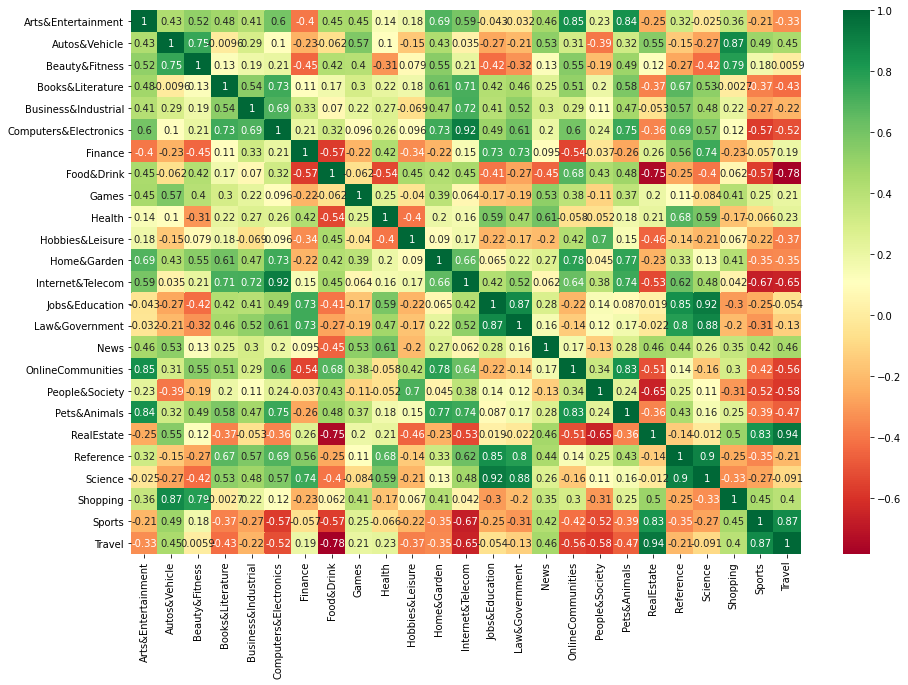

In [136]:
corr_h = sn.heatmap(df_web_search.corr(), annot=True, cmap='RdYlGn')
corr_h.set_yticklabels(corr_h.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig('corr_ws.svg')
plt.show()

#### Pengamatan Korelasi Query-Search

<!-- Strong Positive Correlation : 'Covid', 'Pandemi', 'RapidDiagnosticTest', 'ZonaMerah', 'Zoom'

Strong Negative Correlation : 'HandSanitizer' -->

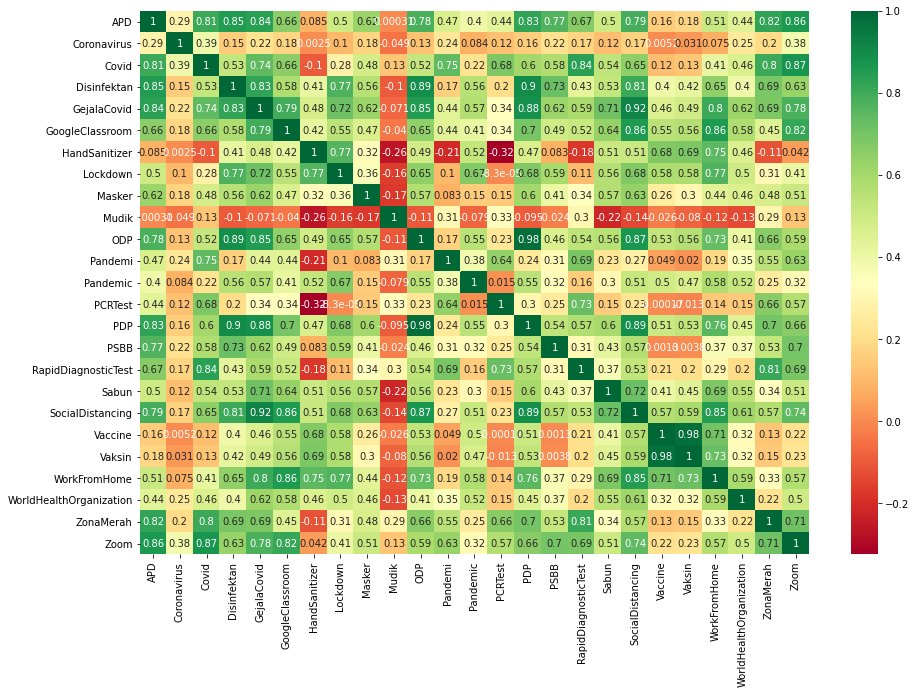

In [137]:
corr_h = sn.heatmap(df_query_search.corr(), annot=True, cmap='RdYlGn')
corr_h.set_yticklabels(corr_h.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig('corr_qs.svg')
plt.show()

In [100]:
# Fitur Terseleksi untuk memprediksi angka pencarian fitur Covid

cor_target = abs(df_query_search.corr()["Covid"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

APD                    0.806643
Covid                  1.000000
Disinfektan            0.525711
GejalaCovid            0.744586
GoogleClassroom        0.655480
ODP                    0.519462
Pandemi                0.745674
PCRTest                0.684641
PDP                    0.602162
PSBB                   0.578293
RapidDiagnosticTest    0.836783
Sabun                  0.538446
SocialDistancing       0.649478
ZonaMerah              0.803837
Zoom                   0.872439
Name: Covid, dtype: float64

In [0]:
df_select = df_query_search[[
  'APD', 'Disinfektan', 'GejalaCovid',
  'GoogleClassroom', 'ODP', 'Pandemi',
  'PCRTest', 'PDP', 'PSBB', 'RapidDiagnosticTest',
  'Sabun', 'SocialDistancing', 'ZonaMerah', 'Zoom',
  'Covid']]

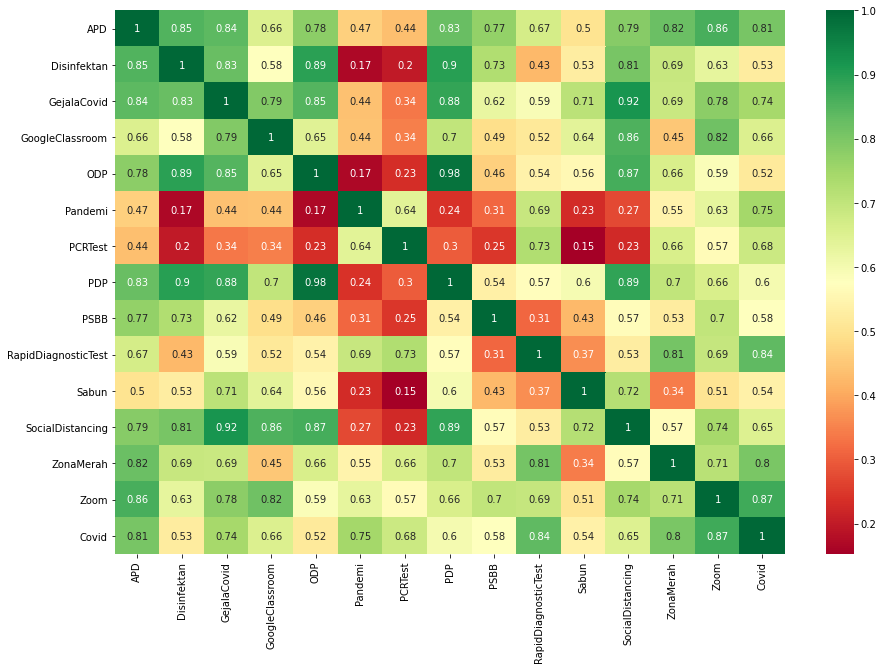

In [135]:
corr_h = sn.heatmap(df_select.corr(), annot=True, cmap='RdYlGn')
corr_h.set_yticklabels(corr_h.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.savefig('corr_select.svg')
plt.show()

### Feature Scaling

Untuk mempermudah model kita mendapatkan hasil yang maksimum, saya akan mempererat nilai dari fitur X supaya mendapatkan nilai antara 0 - 1

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_select_sc = scaler.fit_transform(df_select)

df_select_sc = pd.DataFrame(df_select_sc)

In [104]:
scaler.data_max_

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100.])

### Train-Test Split

Saya akan membagi data training dan data testing menjadi variable yang berbeda.

In [0]:
X = np.array(df_select_sc[list(df_select_sc.columns)[:-1]])
y = np.array(df_select_sc[list(df_select_sc.columns)[-1]])

In [133]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit()
# for train_index, test_index in tscv.split(X):
#   print('TRAIN :', train_index, 'TEST :', test_index)
#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

train_size = 54

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_test.shape)

(24, 14)


In [0]:
# Menyajikan data menjadi data 3-Dimensi untuk LSTM

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [108]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((54, 1, 14), (54,), (10, 1, 14), (10,))

### Membangun Model Prediksi untuk Time Series

In [0]:
# Membangun Model Recurrent Neural Network

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import SGD, Adam

In [0]:
model_type = 1

# Single Cell
if model_type == 1:
  model = Sequential()
  model.add(LSTM(10, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])))
  # model.add(Dropout(0.2))
  model.add(Dense(1))

# Stacked
if model_type == 2:
  model = Sequential()
  model.add(LSTM(10, activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  # model.add(Dropout(0.2))
  model.add(LSTM(10, activation='sigmoid'))
  # model.add(Dropout(0.2))
  model.add(Dense(1))

# Bidirectional
if model_type == 3:
  model = Sequential()
  model.add(Bidirectional(LSTM(10, activation='sigmoid'), input_shape=(X_train.shape[1], X_train.shape[2])))
  # model.add(Dropout(0.2))
  model.add(Dense(1))

sgd = SGD(learning_rate=0.0001)
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae'])

In [0]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=16, verbose=0, shuffle=False)

### Evaluasi Model

Evaluasi Model dengan beberapa parameter, optimizer dan training set yang berbeda.

#### Model 1 : LSTM(10) Single Cell
```
Optimizer  = Adam Standard (Learning Rate)
Epochs     = 1000
BatchSize  = 16
Train Size = 54
Test Size  = 10
```

##### Loss Function (Mean-Squared Error)

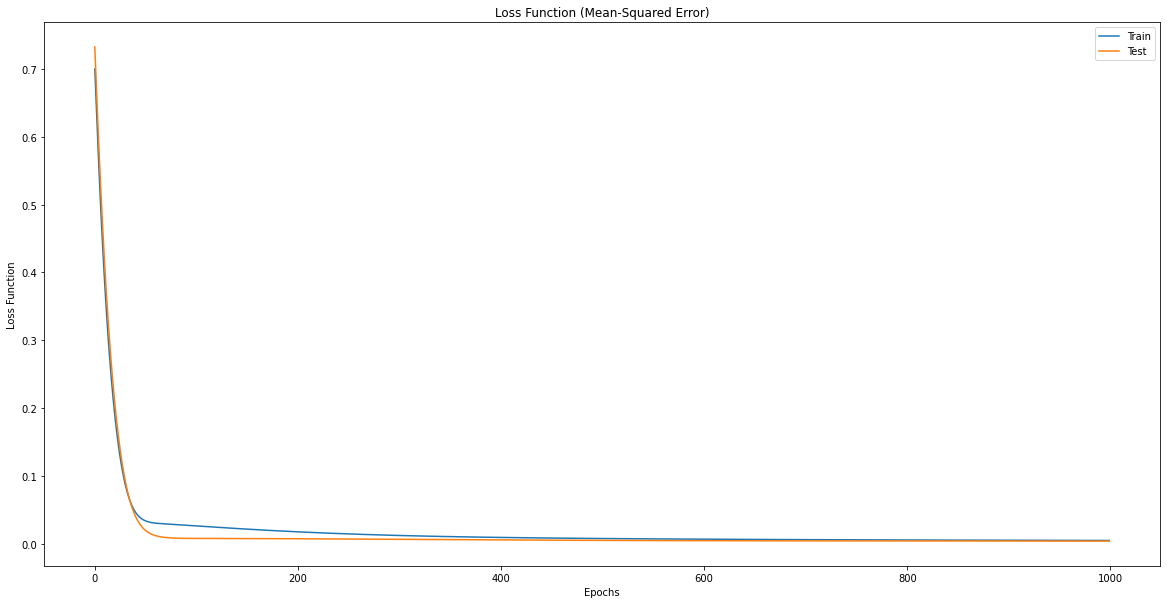

In [112]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss Function (Mean-Squared Error)')
plt.ylabel('Loss Function')
plt.xlabel('Epochs')
plt.legend()
plt.savefig("loss_func.png")
plt.show()

##### Metrics Mean Absolute Error

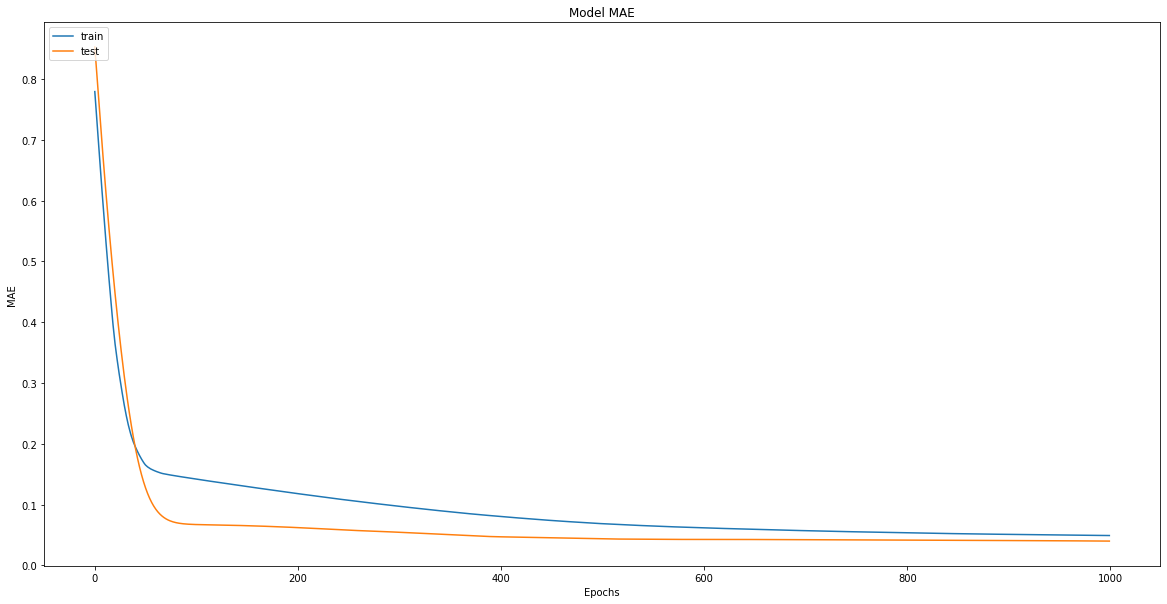

In [113]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Prediksi pada Dataset

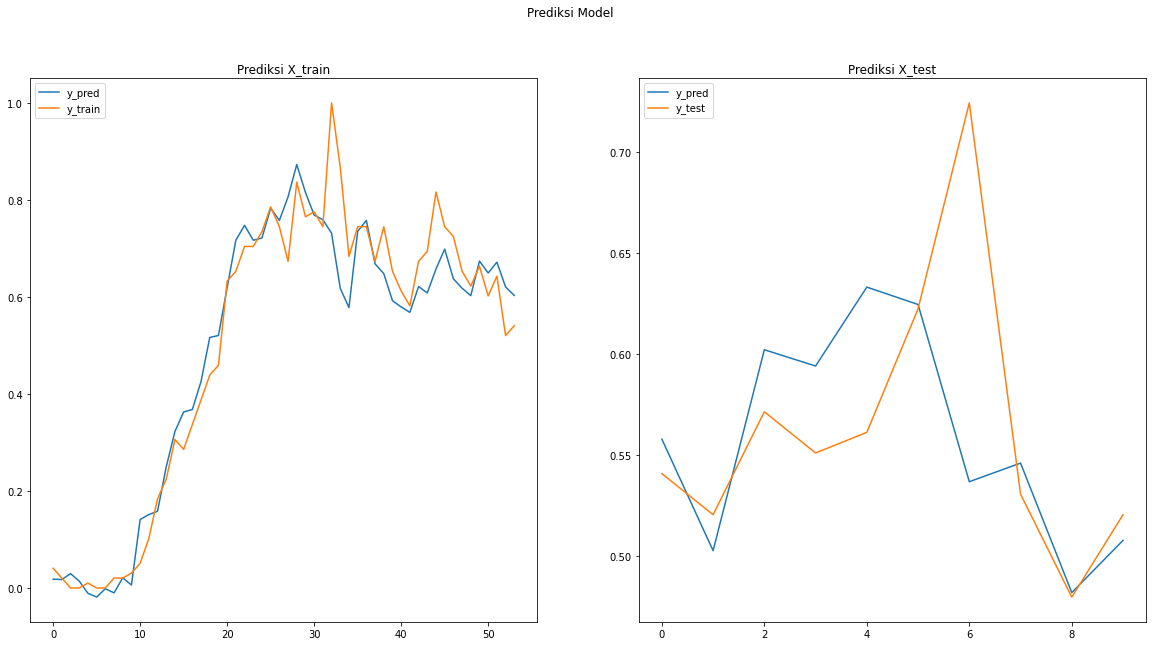

In [114]:
from math import sqrt
from sklearn.metrics import mean_squared_error

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Prediksi Model')
ax1.plot(y_pred_train)
ax1.plot(y_train)
ax1.legend(['y_pred', 'y_train'], loc='upper left')
ax1.set_title('Prediksi X_train')

ax2.plot(y_pred_test)
ax2.plot(y_test)
ax2.legend(['y_pred', 'y_test'], loc='upper left')
ax2.set_title('Prediksi X_test')
plt.show()

#### Model 2 : LSTM(10) Stacked 
```
Optimizer  = Adam Standard (Learning Rate)
Epochs     = 1000
BatchSize  = 16
Train Size = 54
Test Size  = 10
```

##### Loss Function (Mean-Squared Error)

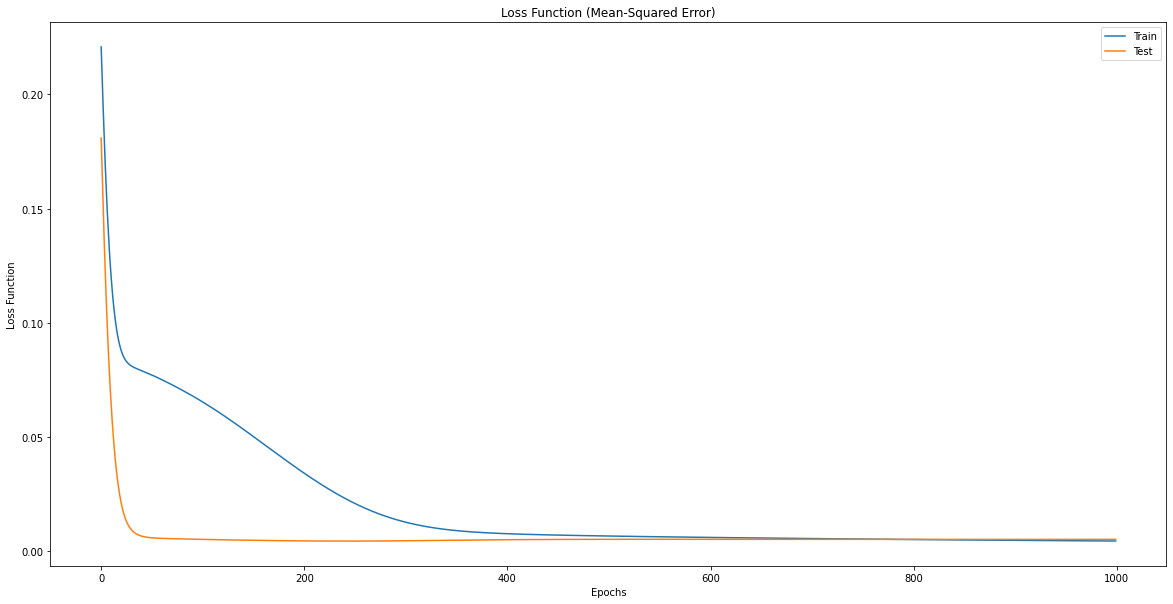

In [118]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss Function (Mean-Squared Error)')
plt.ylabel('Loss Function')
plt.xlabel('Epochs')
plt.legend()
plt.savefig("loss_func.png")
plt.show()

##### Metrics Mean Absolute Error

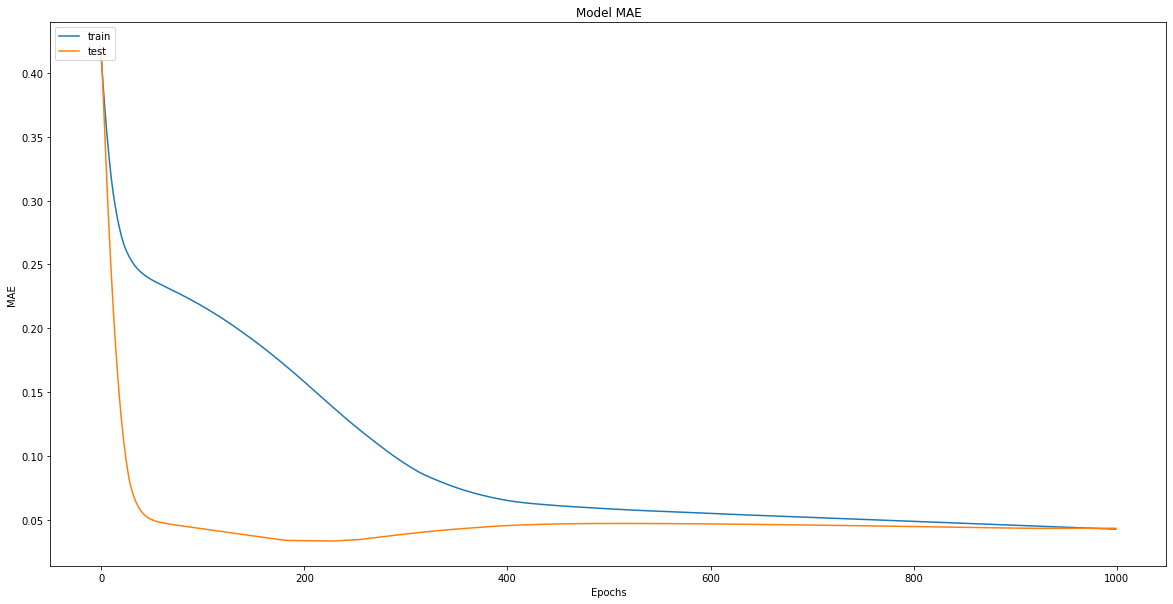

In [119]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Prediksi Pada Dataset

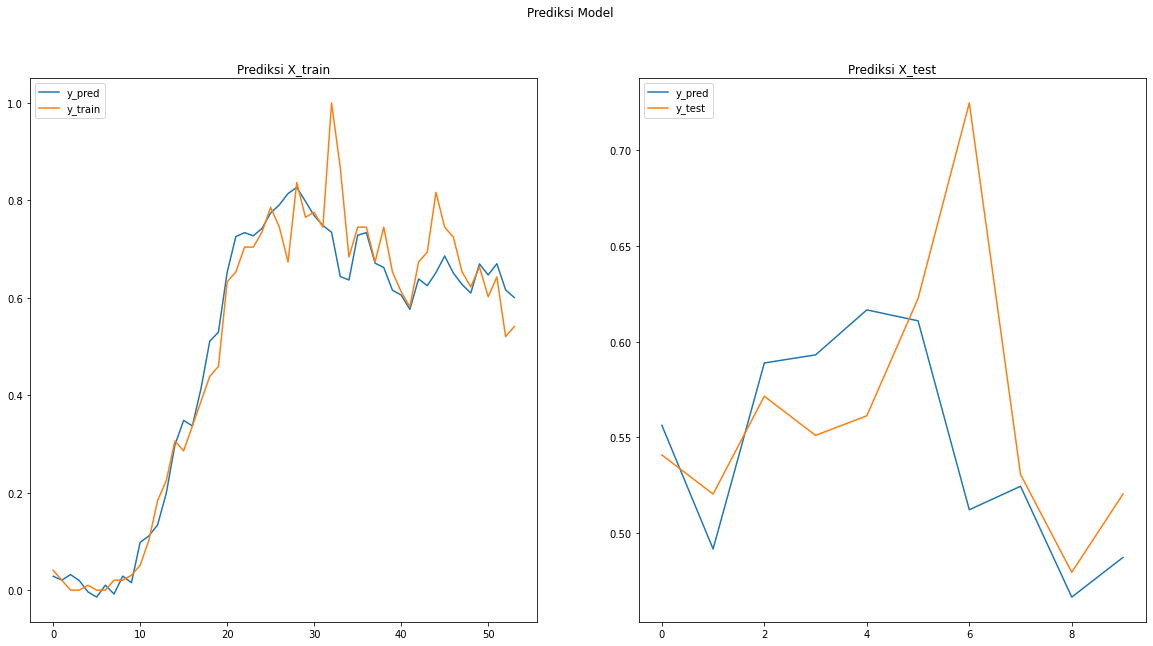

In [120]:
from math import sqrt
from sklearn.metrics import mean_squared_error

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Prediksi Model')
ax1.plot(y_pred_train)
ax1.plot(y_train)
ax1.legend(['y_pred', 'y_train'], loc='upper left')
ax1.set_title('Prediksi X_train')

ax2.plot(y_pred_test)
ax2.plot(y_test)
ax2.legend(['y_pred', 'y_test'], loc='upper left')
ax2.set_title('Prediksi X_test')
plt.show()

#### Model 3 : LSTM(10) Bidirectional 
```
Optimizer  = Adam Standard (Learning Rate)
Epochs     = 1000
BatchSize  = 16
Train Size = 54
Test Size  = 10
```

##### Loss Function (Mean-Squared Error)

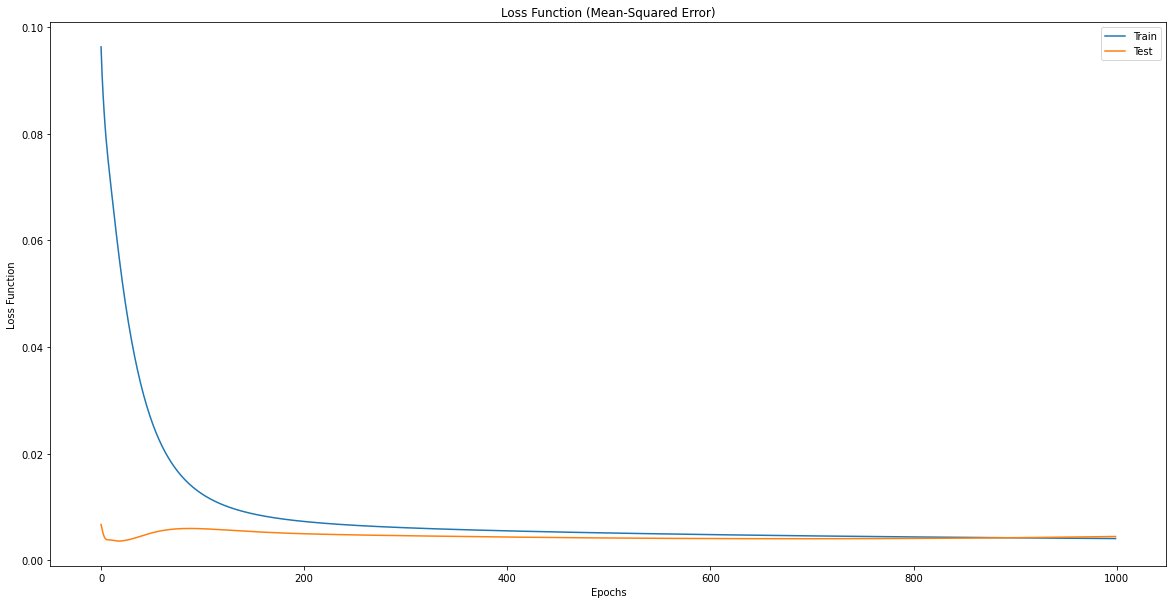

In [124]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss Function (Mean-Squared Error)')
plt.ylabel('Loss Function')
plt.xlabel('Epochs')
plt.legend()
plt.savefig("loss_func.png")
plt.show()

##### Metrics Mean Absolute Error

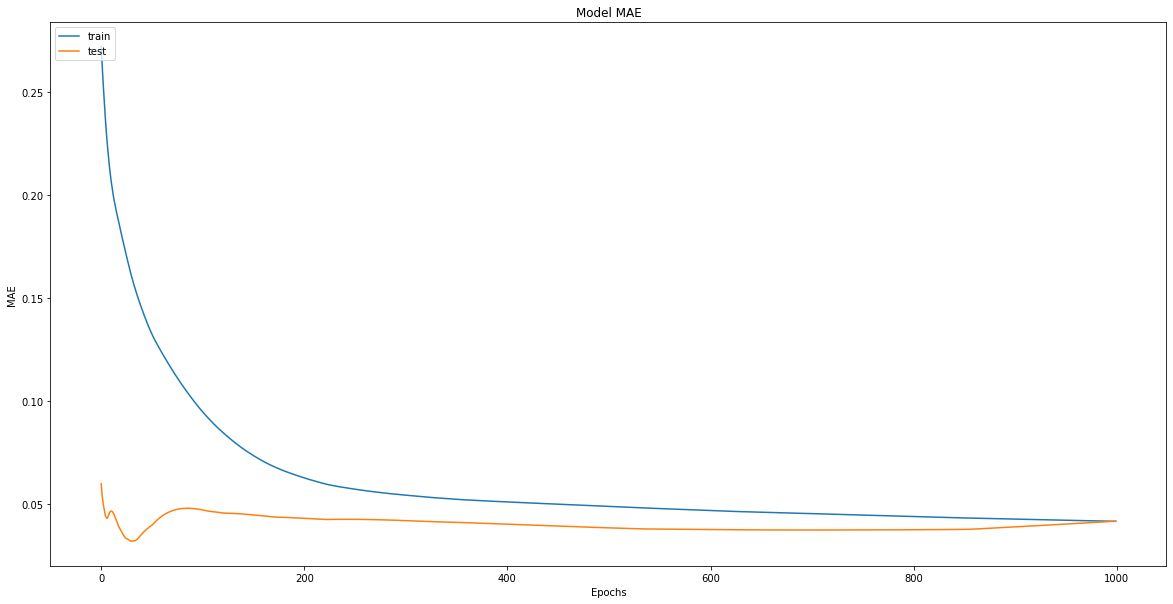

In [125]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Prediksi Pada Dataset

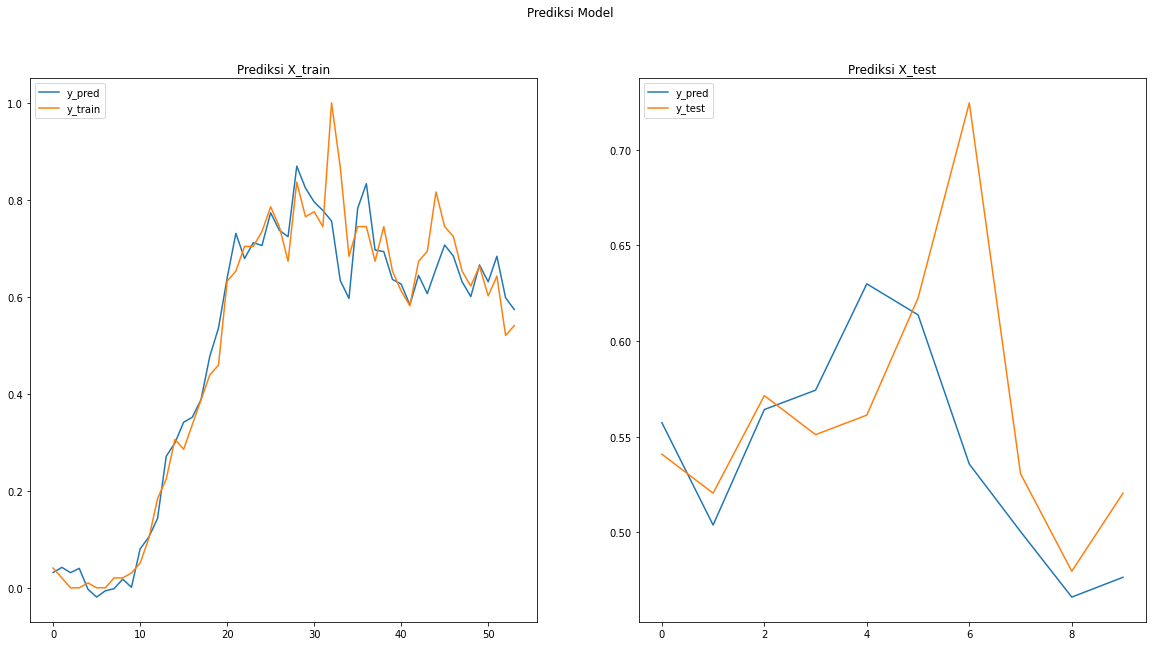

In [126]:
from math import sqrt
from sklearn.metrics import mean_squared_error

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Prediksi Model')
ax1.plot(y_pred_train)
ax1.plot(y_train)
ax1.legend(['y_pred', 'y_train'], loc='upper left')
ax1.set_title('Prediksi X_train')

ax2.plot(y_pred_test)
ax2.plot(y_test)
ax2.legend(['y_pred', 'y_test'], loc='upper left')
ax2.set_title('Prediksi X_test')
plt.show()